In [1]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from bart_representation_analysis import *
from sklearn.decomposition import PCA

set_rc()

In [ ]:

def measure_rnn_influence_multi(res, model, ep, steps, decision_nodes=None, ap=False,
                          large_kick=False):
    '''Measure how much influence individual nodes or group of nodes have on a certain step
    
    decision_nodes: pass boolean array of size 64 to differentiate decision and non-decision nodes
    ap: if True, compute the influence on action probabilities
    '''
    nsteps = len(steps)

    if decision_nodes is not None:
        size = 2
    else:
        size = 64
    
    delt_rnn_sizes = torch.zeros((nsteps, size, 64))
    rnn_hx_mod = torch.zeros((nsteps, size, 64))
    shared0 = torch.zeros((nsteps, size, 64))
    actor0 = torch.zeros((nsteps, size, 64))
    masks = np.array([1.], dtype='float32')
    for i, step in enumerate(steps):
        rnn_hx = torch.tensor(res['rnn_hxs'][ep][step])
        delt_rnn = torch.tensor(res['rnn_hxs'][ep][step+1] - res['rnn_hxs'][ep][step])
        if large_kick:
            delt_rnn = np.sign(delt_rnn) * 1

        for j in range(size):
            rnn_hx_mod[i, j] = rnn_hx
            shared0[i, j] = res['activations']['shared0'][ep][step]
            actor0[i, j] = res['activations']['actor0'][ep][step]
        if decision_nodes is not None:
            rnn_hx_mod[i, 0, decision_nodes] += delt_rnn[decision_nodes]
            rnn_hx_mod[i, 1, ~decision_nodes] += delt_rnn[~decision_nodes]
            delt_rnn_sizes[i, 0, decision_nodes] += delt_rnn[decision_nodes]
            delt_rnn_sizes[i, 1, ~decision_nodes] += delt_rnn[~decision_nodes]
        else:
            for j in range(size):
                rnn_hx_mod[i, j, j] += delt_rnn[j]

    rnn_hx_mod = rnn_hx_mod.reshape(nsteps*size, 64)
    shared0 = shared0.reshape(nsteps*size, 64)

    next_rnn_hx = model.base._forward_gru(shared0, rnn_hx_mod, masks)[0]
    actor0mod = model.base.actor0(next_rnn_hx)
    actor0mod = actor0mod.reshape(nsteps, size, 64)
        
    delt_actor0 = (actor0mod - actor0).detach()
    
    if ap:
        actor1 = model.base.actor1(actor0mod.reshape(nsteps*size, 64))
        logits = model.dist(actor1)
        probs = logits.probs.reshape(nsteps, size, 2)[:, :, 1].detach()
        return delt_actor0, probs

    if decision_nodes is not None:
        return delt_actor0, delt_rnn_sizes
        
    return delt_actor0


def score_decision_flow(res, model, large_kick=False):
    scores = []
    all_dec_nodes = np.full((17, 64), False)
    for ep in range(17):
        presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
        ends = np.array(res['data']['balloon_step'][ep])
        end_presses = np.intersect1d(presses, ends)
        penult_steps = end_presses - 1
        decision_nodes = find_decision_nodes(res, model, ep)
        all_dec_nodes[ep] = decision_nodes
        if decision_nodes.sum() == 0:
            scores.append(np.array([0., 0.]))
            continue
        delt_actor0, delt_rnn_sizes = measure_rnn_influence_multi(res, model, ep, penult_steps,
                                                  decision_nodes=decision_nodes,
                                                  large_kick=large_kick)
        # scores.append(np.abs(delt_actor0).mean(axis=0).var(axis=1).numpy())
        score = np.abs(delt_actor0).mean(axis=(0, 2))
        score[0] = score[0] / decision_nodes.sum()
        score[1] = score[1] / (~decision_nodes).sum()
        scores.append(score)
        
    scores = np.vstack(scores)
    
    return scores, all_dec_nodes

In [315]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 40,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

In [321]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.2n50_0/240.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)

In [345]:
postfix = ''
model = 1.2
t = 2
chk = 100
ep = 12

exp_name = f"p{model}n50{postfix}"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(res['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
decision_nodes = find_decision_nodes(res, model, ep)
delt_actor0, probs = measure_rnn_influence_multi(res, model, ep, penult_steps,
                                            decision_nodes=decision_nodes,
                                            large_kick=False, ap=True)

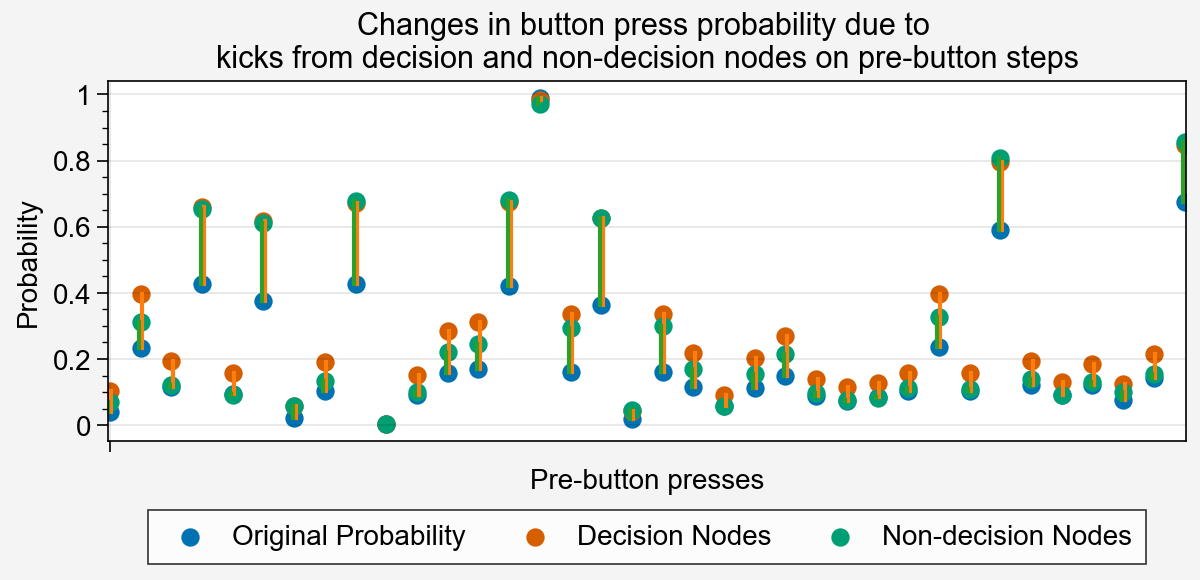

In [283]:
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
true_probs = res['action_probs'][ep][penult_steps, 1]
ax.scatter(true_probs, label='Original Probability')
ax.scatter(probs[:, 0], label='Decision Nodes')
ax.scatter(probs[:, 1], label='Non-decision Nodes')
for i in range(len(true_probs)):
    ax.plot([i+0.05, i+0.05], [true_probs[i], probs[i, 0]], c=rgb_colors[1])
    ax.plot([i-0.05, i-0.05], [true_probs[i], probs[i, 1]], c=rgb_colors[2])
    
ax.legend(loc='b')
ax.format(xlabel='Pre-button presses', xlocator=range(1), xformatter=[''],
          ylabel='Probability', 
          title='Changes in button press probability due to \nkicks from decision and non-decision nodes on pre-button steps')

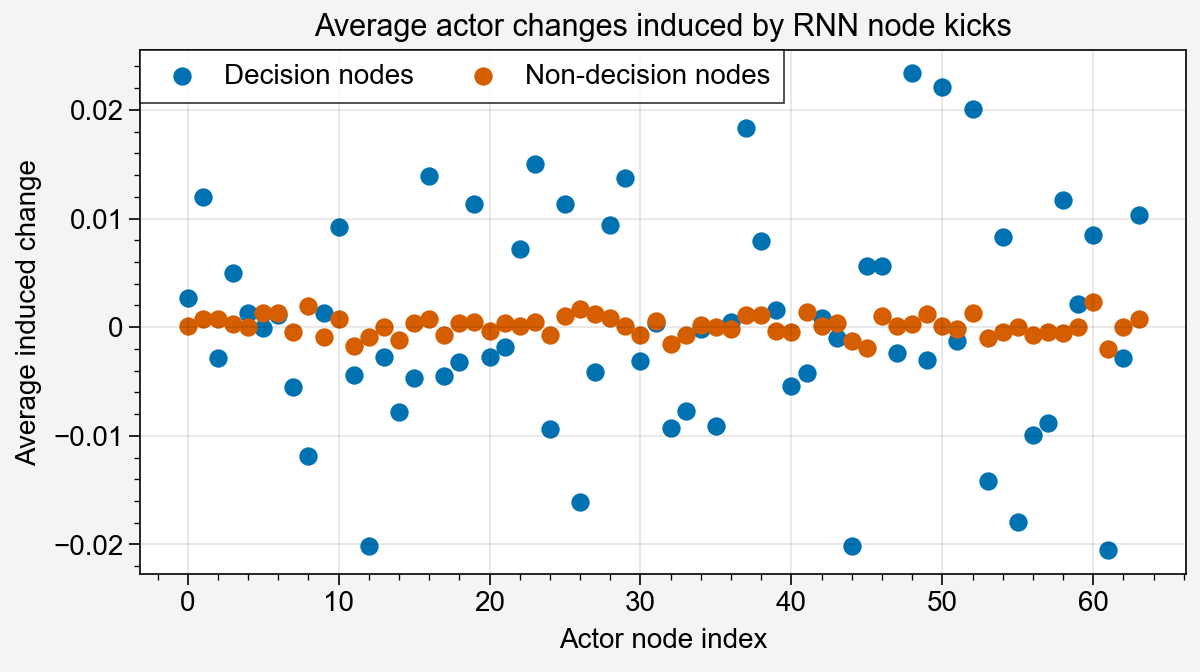

In [296]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

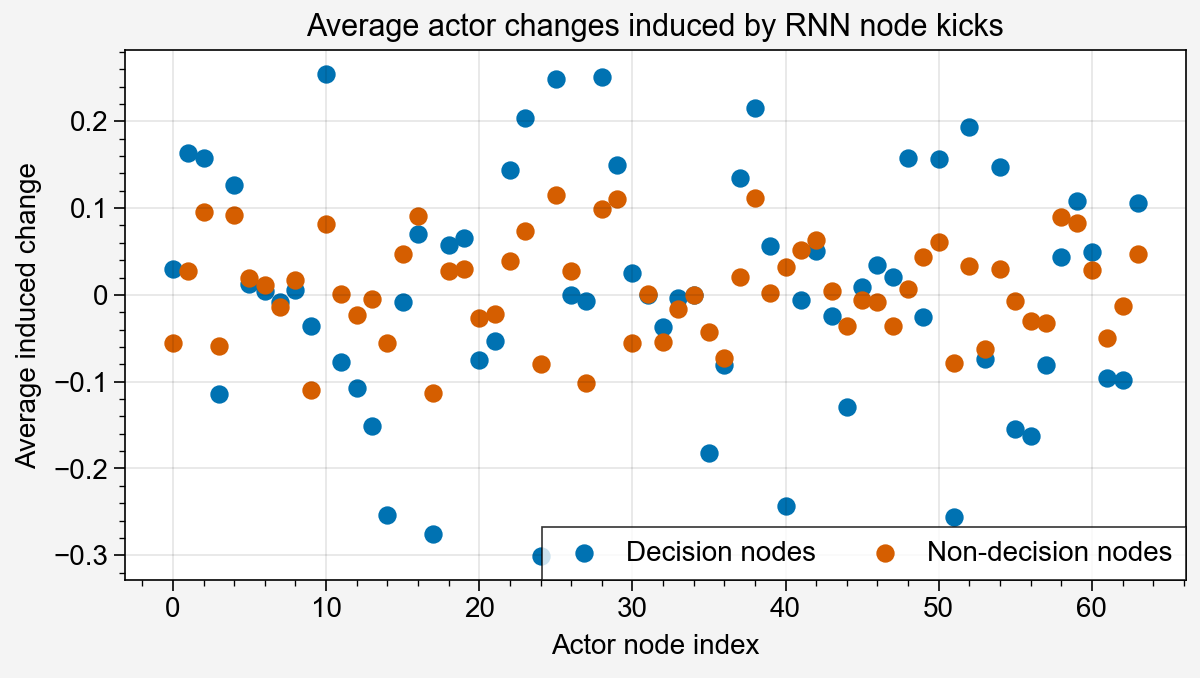

In [346]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0], label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1], label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

In [352]:
(delt_actor0[step_idx, 1].sign() == delt_actor0[step_idx, 0].sign()).sum()

tensor(51)

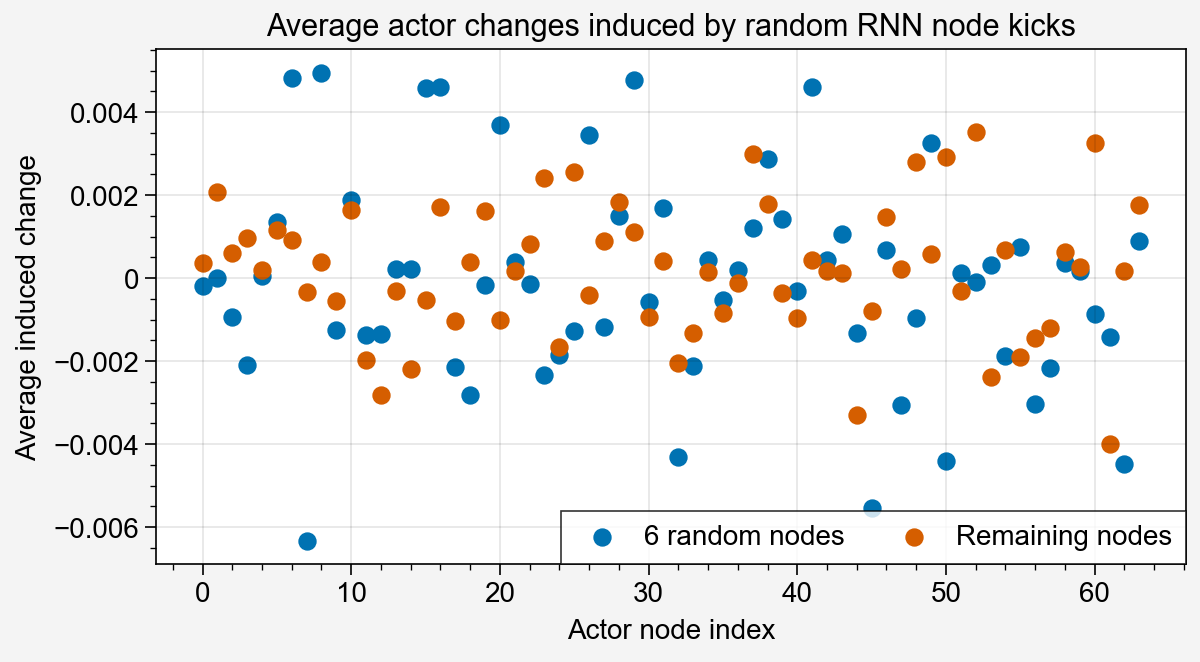

In [304]:
postfix = ''
model = 1.2
t = 2
chk = 100
ep = 12

exp_name = f"p{model}n50{postfix}"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(res['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
# decision_nodes = find_decision_nodes(res, model, ep)
random_nodes = np.full(64, False)
random_nodes[np.random.choice(np.arange(64), (6,))] = True
delt_actor0, probs = measure_rnn_influence_multi(res, model, ep, penult_steps,
                                            decision_nodes=random_nodes,
                                            large_kick=False, ap=True)
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='6 random nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Remaining nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by random RNN node kicks')
ax.legend()

In [192]:
"""
Main section to collect a bunch of data on confidence
and activations
"""


import warnings
warnings.filterwarnings("ignore")

postfixes = ['', 'pop0.05', 'pop0.1']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

dec_flow_scores = np.zeros(sizes + [2]) # last axis: 0=decision nodes, 1=non-dec nodes
all_decision_nodes = np.zeros(sizes + [17, 64])

for i, j, k, l in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    exp_name = f"p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
    res = evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=40)
    
    score, dec_nodes = score_decision_flow(res, model)
    dec_flow_scores[i, j, k, l] = score.mean(axis=0)
    all_decision_nodes[i, j, k, l] = dec_nodes
        
pickle.dump({
    'dec_flow_scores': dec_flow_scores,
    'all_decision_nodes': all_decision_nodes
}, open('data/meta_rnn_decision_flows', 'wb'))
    

100%|██████████| 360/360 [35:39<00:00,  5.94s/it]


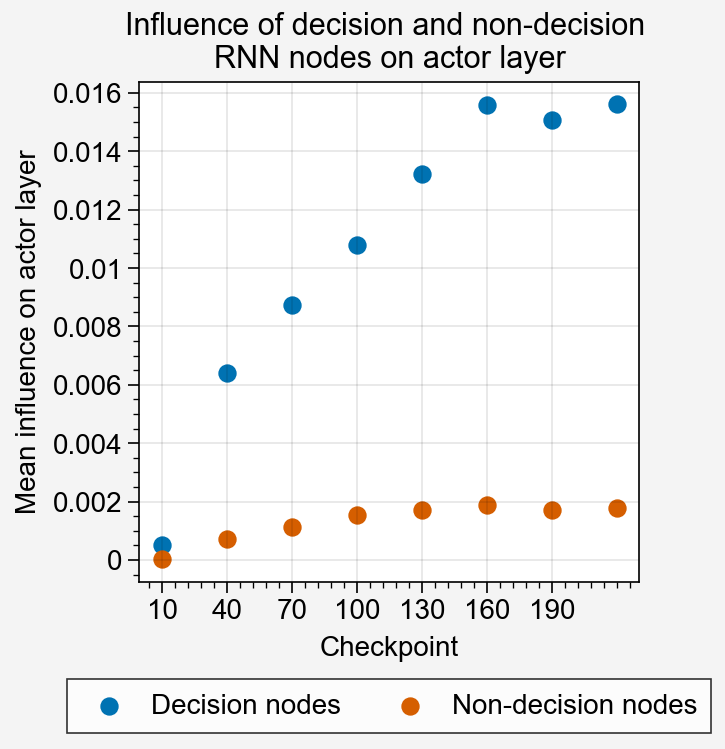

In [197]:
fig, ax = pplt.subplots()
ax.scatter(dec_flow_scores.mean(axis=(0, 1, 2))[:, 0], label='Decision nodes')
ax.scatter(dec_flow_scores.mean(axis=(0, 1, 2))[:, 1], label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(7), xformatter=[str(c) for c in chks],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer')

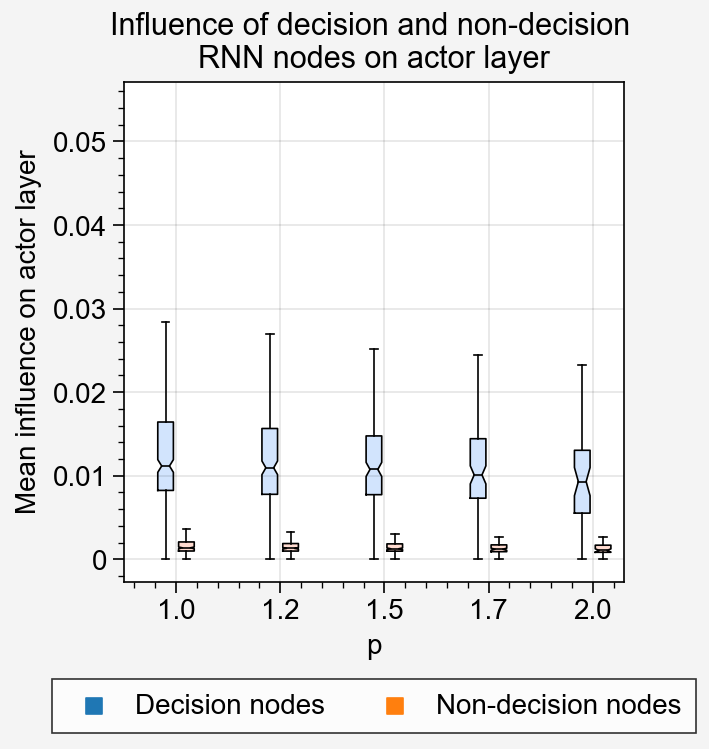

In [232]:
fig, ax = pplt.subplots()
for i in range(len(models)):
    dec = dec_flow_scores[:, i:, :, :, 0].reshape(-1)
    nondec = dec_flow_scores[:, i:, :, :, 1].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, fc=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, fc=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='$p$', xlocator=np.arange(5)+0.1, xformatter=[str(m) for m in models],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 4.4])

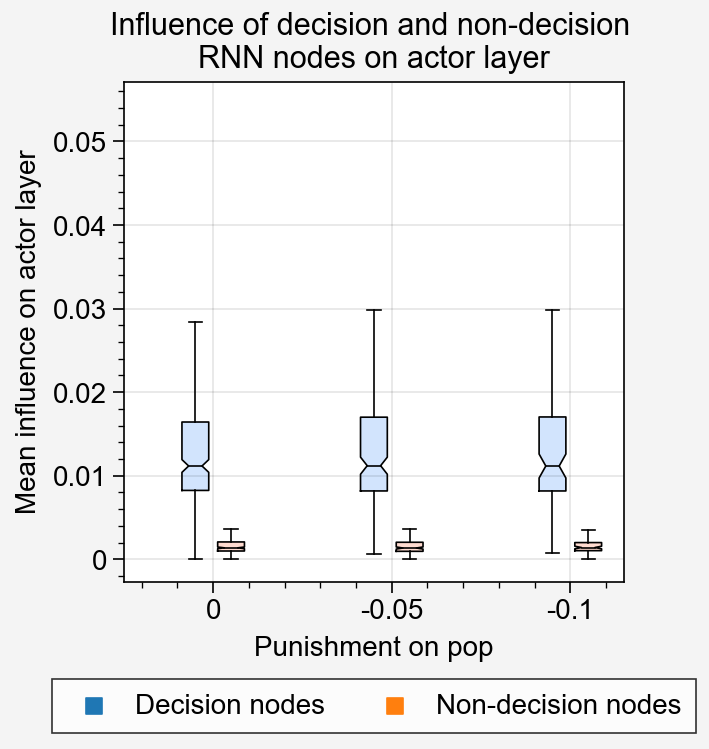

In [231]:
fig, ax = pplt.subplots()
for i in range(len(postfixes)):
    dec = dec_flow_scores[i:, :, :, :, 0].reshape(-1)
    nondec = dec_flow_scores[i:, :, :, :, 1].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, fc=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, fc=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='Punishment on pop', xlocator=np.arange(3)+0.1, xformatter=['0', '-0.05', '-0.1'],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 2.4])

## Decision node counts

In [353]:
all_decision_nodes.shape

(3, 5, 3, 8, 17, 64)

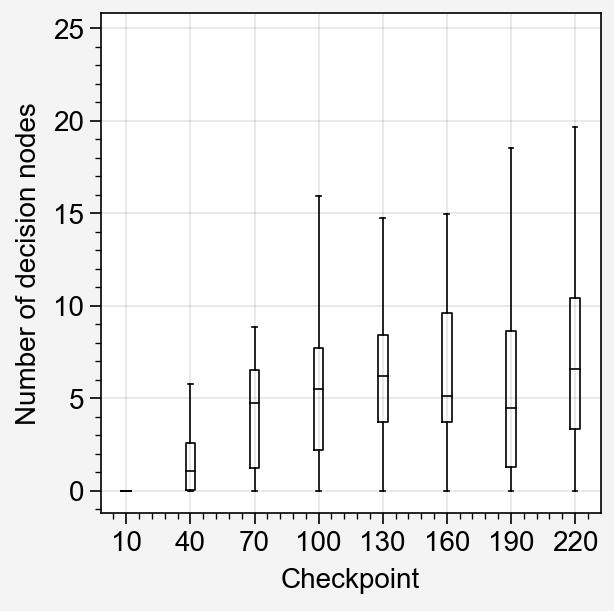

In [356]:
fig, ax = pplt.subplots()
for i in range(len(chks)):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(0, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(i, all_decision_nodes.sum(axis=5).mean(axis=4)[:, :, :, i].reshape(-1), fliers=False)
        
# ax.legend(loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(17), xformatter=[str(c) for c in chks],
            ylabel='Number of decision nodes',
            title='',
            xlim=[-0.4, 7.4])

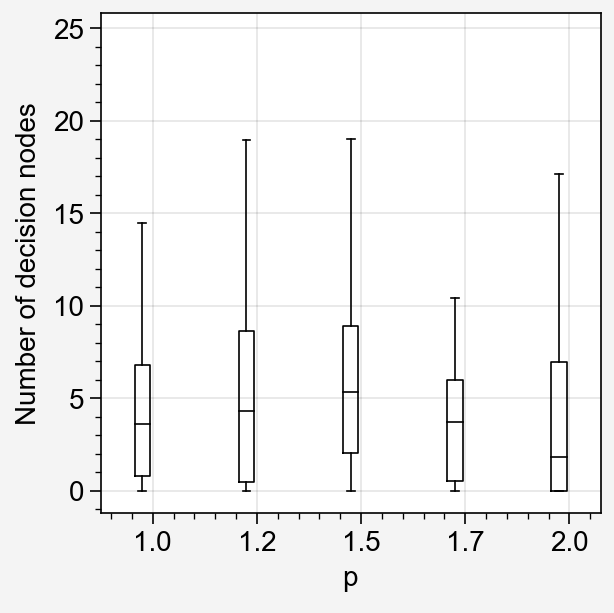

In [342]:
fig, ax = pplt.subplots()
for i in range(len(models)):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(0, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(i, all_decision_nodes.sum(axis=5).mean(axis=4)[:, i, :, :].reshape(-1), fliers=False)
        
# ax.legend(loc='b')
ax.format(xlabel='$p$', xlocator=np.arange(5)+0.1, xformatter=[str(m) for m in models],
            ylabel='Number of decision nodes',
            title='',
            xlim=[-0.4, 4.4])

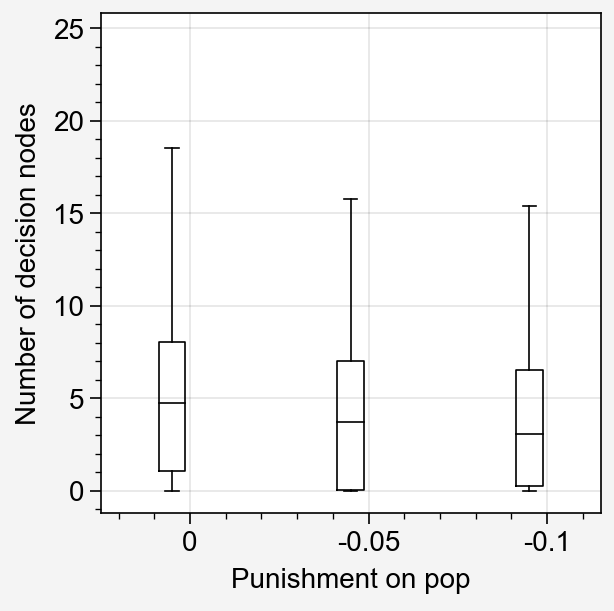

In [343]:
fig, ax = pplt.subplots()
for i in range(len(postfixes)):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(1, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(i, all_decision_nodes.sum(axis=5).mean(axis=4)[i, :, :, :].reshape(-1), fliers=False)
# ax.legend(loc='b')
ax.format(xlabel='Punishment on pop', xlocator=np.arange(3)+0.1, xformatter=['0', '-0.05', '-0.1'],
            ylabel='Number of decision nodes',
            title='',
            xlim=[-0.4, 2.4])

# Decision node consistency

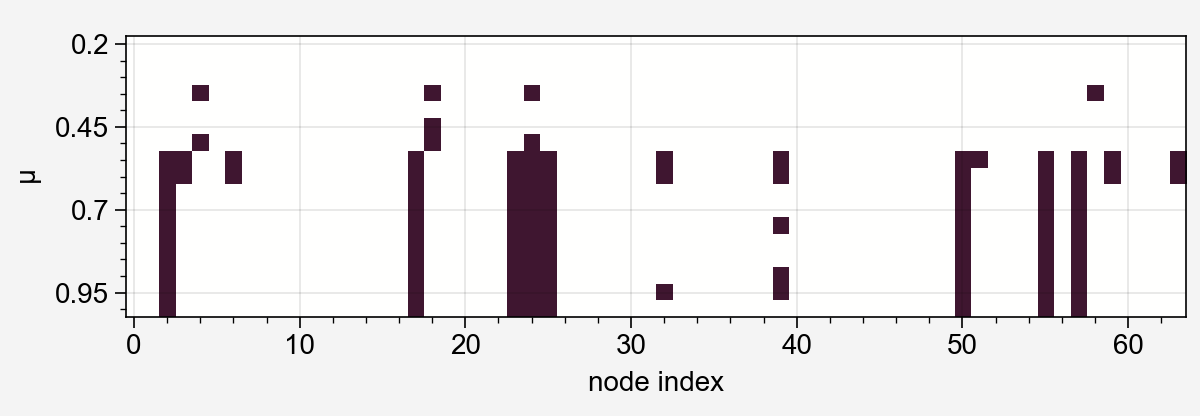

In [331]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.2n50_0/100.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)
all_dec_nodes = np.zeros((17, 64))
for ep in range(17):
    decision_nodes = find_decision_nodes(res, model, ep)
    all_dec_nodes[ep] = decision_nodes*1
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
ax.imshow(all_dec_nodes)
ax.format(xlabel='node index', ylabel='$\mu$', ylocator=np.arange(0, 16, 5), yrotation=0,
          yformatter=[str(m) for m in np.arange(0, 16, 5)*0.05+0.2])

### Same episode consistency

In [71]:
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 40,
                            'inflate_noise': 0,
                            'fix_sizes': [0, 0.5, 0]} for i in range(20)]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=20,
                seed=1,
                deterministic=False,
                with_activations=True)

In [322]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.2n50_0/240.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)

In [323]:
all_dec_nodes = np.zeros((20, 64))
for ep in range(20):
    decision_nodes = find_decision_nodes(res, model, ep)
    all_dec_nodes[ep] = decision_nodes*1
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
ax.imshow(all_dec_nodes)

IndexError: list index out of range

array([57, 30, 29, 43, 20, 13, 25, 16, 46, 26,  9, 28, 19, 34, 17])

In [94]:
idxs

array([49, 15, 55, 38, 10, 51, 42, 25, 26, 17, 28, 14, 37,  0, 57])

In [98]:
all_dec_nodes.sum()

300.0

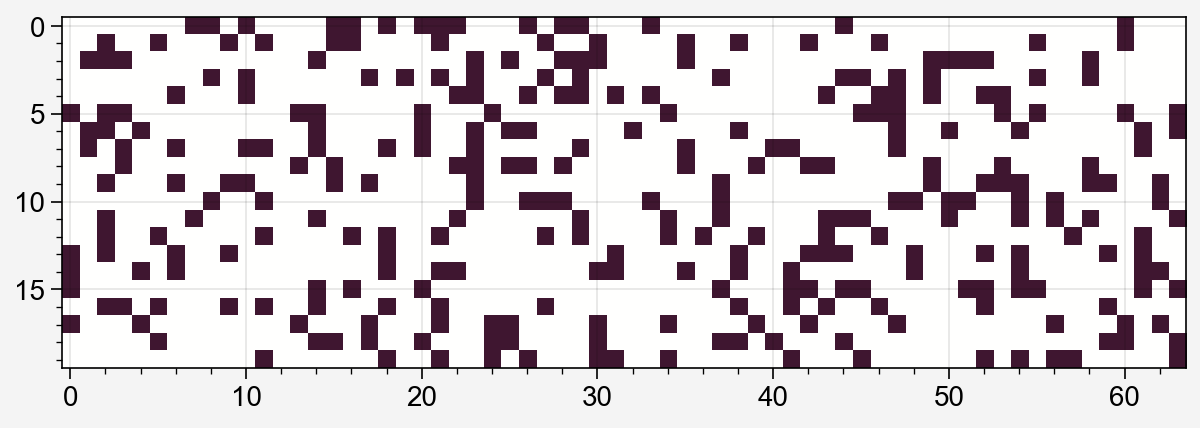

In [99]:
all_dec_nodes = np.zeros((20, 64))
for ep in range(20):
    idxs = np.random.choice(np.arange(64), size=15, replace=False)
    all_dec_nodes[ep, idxs] = 1
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
ax.imshow(all_dec_nodes)